In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import Normalize
import numpy as np

from model import CNNModel, MultiLabelDataset

from crp.helper import get_layer_names
from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
from crp.attribution import CondAttribution

from crp.concepts import ChannelConcept

%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load model and dataset

In [93]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is:" + str(device))

device is:cuda


In [95]:
dataset = MultiLabelDataset(os.path.join("..", "generatingSpectograms", "crp_dataset", "crp_annotation.csv"), image_dir=os.path.join("..", "generatingSpectograms", "crp_dataset", "spectrograms"))

In [96]:
model = torch.load('model400x400.pt').to(device)
model.eval()

CNNModel(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=67712, out_features=12, bias=True)
)

# Concept relevance propagation

## configure library settings

In [97]:
cc = ChannelConcept()

In [98]:
composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])
attribution = CondAttribution(model, no_param_grad=True)

## experiments

### Display an example ###

Acoustic Grand Piano: tensor(1.)
Nylon Acoustic Guitar: tensor(0.)
String Ensemble 1: tensor(0.)
Piccolo: tensor(0.)
Celesta: tensor(0.)
Acoustic Bass: tensor(0.)
Trumpet: tensor(1.)
Square Wave Lead: tensor(0.)
Hammond Organ: tensor(0.)
Violin: tensor(1.)
Soprano Sax: tensor(0.)
New Age Pad: tensor(1.)


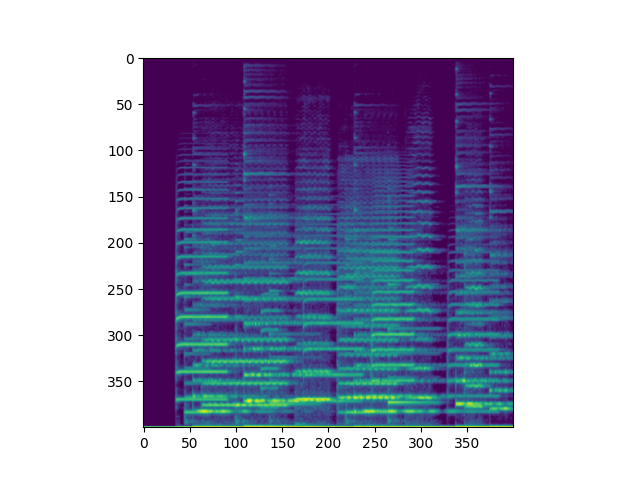

model output for this example
Acoustic Grand Piano: 1.0346991
Nylon Acoustic Guitar: -4.171437
String Ensemble 1: -8.197467
Piccolo: -5.7006965
Celesta: -11.924858
Acoustic Bass: -1.8922293
Trumpet: 10.197523
Square Wave Lead: -7.0620217
Hammond Organ: -9.542273
Violin: 15.485581
Soprano Sax: -2.093559
New Age Pad: 7.184804


In [102]:
image, label = dataset[8]  # choose example from dataset here
for i in range(0, (len(dataset.label_columns))):
    print(dataset.label_columns[i] + ": " + str(label[i]))
plt.figure()
plt.imshow(image.permute(1, 2, 0))
plt.show()

print("model output for this example")
model_output = model(image.to(device).unsqueeze(0)).to("cpu").numpy()
for i in range(0, (len(dataset.label_columns))):
    print(dataset.label_columns[i] + ": " + str(model_output[0, i]))

### View concept relevance propagation attribution ###

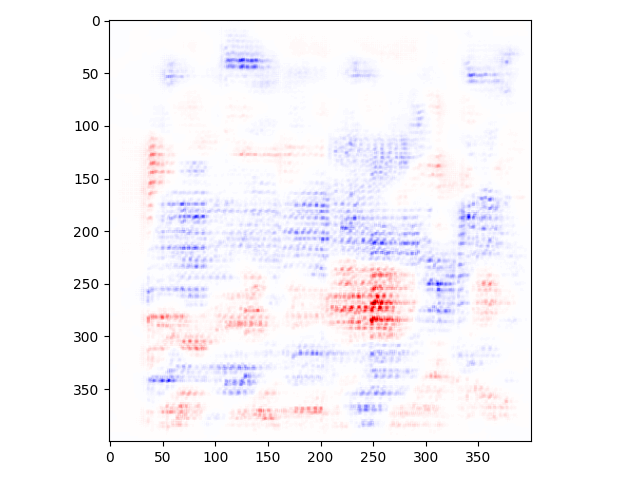

In [100]:
# analyse in regard to a single class

conditions = [{"y": 2}] # put instrument class number here

sample = image.detach().requires_grad_(True).to(device).unsqueeze(0)

attr = attribution(sample, conditions, composite, mask_map=cc.mask)

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
mask_map = {name: cc.mask for name in layer_names}

attr = attribution(sample, conditions, composite, mask_map=mask_map)

max_val = torch.max(torch.abs(attr.heatmap))
norm = Normalize(vmin=-max_val, vmax=max_val)
plt.figure()
plt.imshow(attr.heatmap.permute(1, 2, 0).to('cpu'), cmap="seismic", norm=norm)
plt.tight_layout()
plt.show()

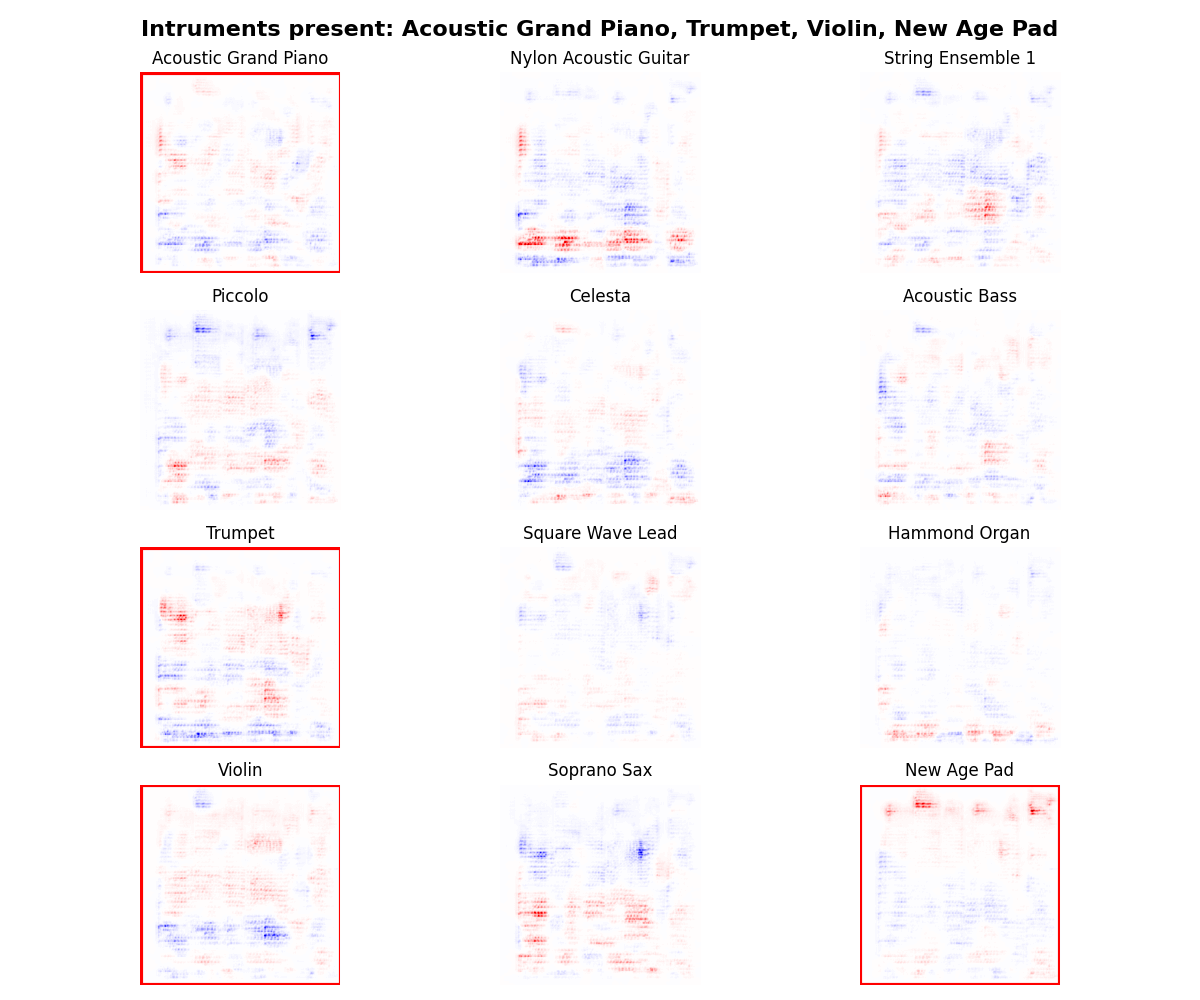

In [101]:
# analyse in regard to all classes

sample = image.detach().requires_grad_(True).to(device).unsqueeze(0)

rows, cols = 4, 3
fig, axes = plt.subplots(rows, cols, figsize=(12, 10))

real_classes = "Intruments present: "
for i in range(0, (len(dataset.label_columns))):
    if label[i] == 1:
        real_classes = real_classes + dataset.label_columns[i] + ", "
fig.suptitle(real_classes[:-2], fontsize=16, fontweight='bold')

axes = axes.flatten()

active_instruments = np.where(label.to('cpu').numpy() == 1)[0]
attrs = []
max_val = 0
for i, ax in enumerate(axes):
    conditions = [{"y": i}]
    attr = attribution(sample, conditions, composite, mask_map=cc.mask)
    layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
    mask_map = {name: cc.mask for name in layer_names}
    attr = attribution(sample, conditions, composite, mask_map=mask_map)
    attrs.append(attr)
    max_val = max(max_val, torch.max(torch.abs(attr.heatmap)).to("cpu").numpy())

norm = Normalize(vmin=-max_val, vmax=max_val)
for i, ax in enumerate(axes):
    if i in active_instruments:
        rect = patches.Rectangle(
            (0, 0),
            sample.shape[-2],
            sample.shape[-1],
            linewidth=3,
            edgecolor='red',
            facecolor='none',
            transform=ax.transData,
        )
        ax.add_patch(rect)
    ax.imshow(attrs[i].heatmap.permute(1, 2, 0).to('cpu'), cmap="seismic", norm=norm)  
    ax.set_title(dataset.label_columns[i])          
    ax.axis('off')                    

plt.tight_layout()
plt.show()